<a href="https://colab.research.google.com/github/arai37ASU/CSE572_HW3/blob/main/HW3_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 – Recommender System with MovieLens


In [ ]:
!pip install scikit-surprise

First few rows of the data:


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Loaded dataset for Surprise.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

=== 3(c) & 3(d): Average RMSE / MAE over 5 folds ===


,Model,RMSE,MAE
0,PMF (SVD),1.012987,0.780307
1,User-based CF,0.993150,0.767113
2,Item-based CF,0.995100,0.774792


Best model in terms of RMSE: User-based CF
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,Similarity,RMSE,MAE
0,cosine,0.993150,0.767113
1,msd,0.967779,0.743735
2,pearson,0.998342,0.773051



=== 3(e) Item-based CF: different similarity metrics ===


,Similarity,RMSE,MAE
0,cosine,0.995100,0.774792
1,msd,0.934569,0.721045
2,pearson,0.989143,0.768500


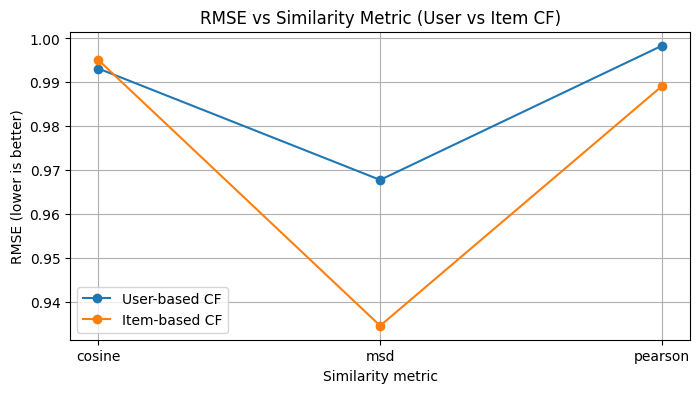

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

,K,User_CF_RMSE,Item_CF_RMSE
0,5,1.043954,1.100925
1,10,1.009122,1.050768
2,20,0.996640,1.017126
3,40,0.993150,0.995100
4,60,0.993293,0.985795
5,80,0.993711,0.980777
6,100,0.994336,0.977754


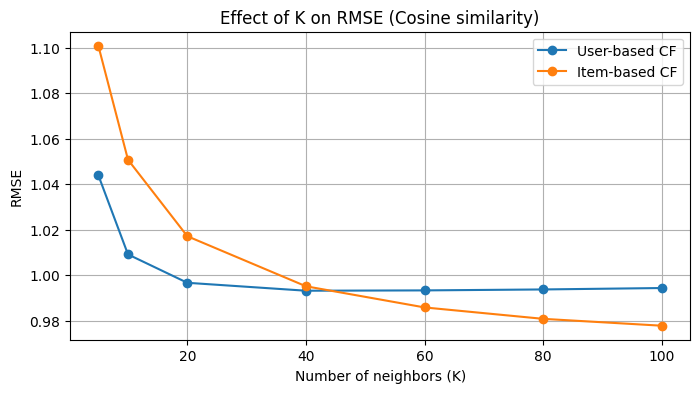

Best K for User-based CF (lowest RMSE): 40
Best K for Item-based CF (lowest RMSE): 100
The best K is DIFFERENT for User and Item CF.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate, KFold


# (a) Load data from ratings_small
excel_path = "HW3 Dataset/ratings_small.xlsx"   # adjust if your path is different
csv_path = "ratings_small.csv"

# read from excel and save to csv (only once; running again just overwrites)
df = pd.read_excel(excel_path)
df = df[["userId", "movieId", "rating", "timestamp"]]   # keep only the needed columns
df.to_csv(csv_path, index=False)

print("First few rows of the data:")
display(df.head())

# Surprise needs: user item rating timestamp, comma separated, no header on read
reader = Reader(
    line_format="user item rating timestamp",
    sep=",",
    rating_scale=(0.5, 5.0),   # MovieLens ratings go from 0.5 to 5
    skip_lines=1               # skip header line
)

data = Dataset.load_from_file(csv_path, reader=reader)
print("Loaded dataset for Surprise.")


# small helper to evaluate an algorithm with 5-fold CV
def eval_algo(algo, data, cv):
    cv_results = cross_validate(algo,
                                data,
                                measures=["RMSE", "MAE"],
                                cv=cv,
                                verbose=False)
    mean_rmse = np.mean(cv_results["test_rmse"])
    mean_mae = np.mean(cv_results["test_mae"])
    return mean_rmse, mean_mae


# use fixed 5-fold split so everyone is comparable
kf = KFold(n_splits=5, random_state=42, shuffle=True)


# (c) Average MAE / RMSE for PMF, User-CF, Item-CF


# PMF ≈ plain SVD without biases
pmf = SVD(biased=False, random_state=42)

# User-based CF with cosine similarity
user_cf_cos = KNNBasic(
    k=40,
    sim_options={"name": "cosine", "user_based": True}
)

# Item-based CF with cosine similarity
item_cf_cos = KNNBasic(
    k=40,
    sim_options={"name": "cosine", "user_based": False}
)

pmf_rmse, pmf_mae       = eval_algo(pmf, data, kf)
user_rmse, user_mae     = eval_algo(user_cf_cos, data, kf)
item_rmse, item_mae     = eval_algo(item_cf_cos, data, kf)

results_cd = pd.DataFrame({
    "Model": ["PMF (SVD)", "User-based CF", "Item-based CF"],
    "RMSE":  [pmf_rmse,    user_rmse,      item_rmse],
    "MAE":   [pmf_mae,     user_mae,       item_mae],
})

print("\n=== 3(c) & 3(d): Average RMSE / MAE over 5 folds ===")
display(results_cd)

best_model_idx = np.argmin(results_cd["RMSE"].values)
print("Best model in terms of RMSE:", results_cd.loc[best_model_idx, "Model"])



# (e) Effect of similarity metric (cosine, MSD, Pearson)

sim_names = ["cosine", "msd", "pearson"]

user_sim_results = []
item_sim_results = []

for sim in sim_names:
    # user-based
    algo_u = KNNBasic(
        k=40,
        sim_options={"name": sim, "user_based": True}
    )
    rmse_u, mae_u = eval_algo(algo_u, data, kf)
    user_sim_results.append((sim, rmse_u, mae_u))

    # item-based
    algo_i = KNNBasic(
        k=40,
        sim_options={"name": sim, "user_based": False}
    )
    rmse_i, mae_i = eval_algo(algo_i, data, kf)
    item_sim_results.append((sim, rmse_i, mae_i))

user_sim_df = pd.DataFrame(user_sim_results, columns=["Similarity", "RMSE", "MAE"])
item_sim_df = pd.DataFrame(item_sim_results, columns=["Similarity", "RMSE", "MAE"])

print("\n=== 3(e) User-based CF: different similarity metrics ===")
display(user_sim_df)

print("\n=== 3(e) Item-based CF: different similarity metrics ===")
display(item_sim_df)

# plot RMSE vs similarity type
plt.figure(figsize=(8,4))
plt.plot(user_sim_df["Similarity"], user_sim_df["RMSE"], marker="o", label="User-based CF")
plt.plot(item_sim_df["Similarity"], item_sim_df["RMSE"], marker="o", label="Item-based CF")
plt.title("RMSE vs Similarity Metric (User vs Item CF)")
plt.ylabel("RMSE (lower is better)")
plt.xlabel("Similarity metric")
plt.legend()
plt.grid(True)
plt.show()


# (f) Effect of number of neighbors K

k_values = [5, 10, 20, 40, 60, 80, 100]

user_k_rmse = []
item_k_rmse = []

for k in k_values:
    algo_u = KNNBasic(
        k=k,
        sim_options={"name": "cosine", "user_based": True}
    )
    rmse_u, _ = eval_algo(algo_u, data, kf)
    user_k_rmse.append(rmse_u)

    algo_i = KNNBasic(
        k=k,
        sim_options={"name": "cosine", "user_based": False}
    )
    rmse_i, _ = eval_algo(algo_i, data, kf)
    item_k_rmse.append(rmse_i)

k_df = pd.DataFrame({
    "K": k_values,
    "User_CF_RMSE": user_k_rmse,
    "Item_CF_RMSE": item_k_rmse
})

print("\n=== 3(f) RMSE vs number of neighbors K ===")
display(k_df)

# line plot: K vs RMSE
plt.figure(figsize=(8,4))
plt.plot(k_values, user_k_rmse, marker="o", label="User-based CF")
plt.plot(k_values, item_k_rmse, marker="o", label="Item-based CF")
plt.title("Effect of K on RMSE (Cosine similarity)")
plt.xlabel("Number of neighbors (K)")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()


# (g) Best K for User / Item CF (w.r.t RMSE)

best_user_idx = int(np.argmin(user_k_rmse))
best_item_idx = int(np.argmin(item_k_rmse))

best_k_user = k_values[best_user_idx]
best_k_item = k_values[best_item_idx]

print(f"Best K for User-based CF (lowest RMSE): {best_k_user}")
print(f"Best K for Item-based CF (lowest RMSE): {best_k_item}")

if best_k_user == best_k_item:
    print("The best K is the SAME for User and Item CF.")
else:
    print("The best K is DIFFERENT for User and Item CF.")
